# Hieroglyph Classification and Custom Data Preparation
This notebook implements 3 CNN architectures to classify hieroglyph symbols. It includes data preparation, preprocessing, model training, and evaluation.


# importing required libraries

In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import shutil
import hashlib
import logging
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.applications import Xception,  VGG16, InceptionV3
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, SeparableConv2D, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset preparation

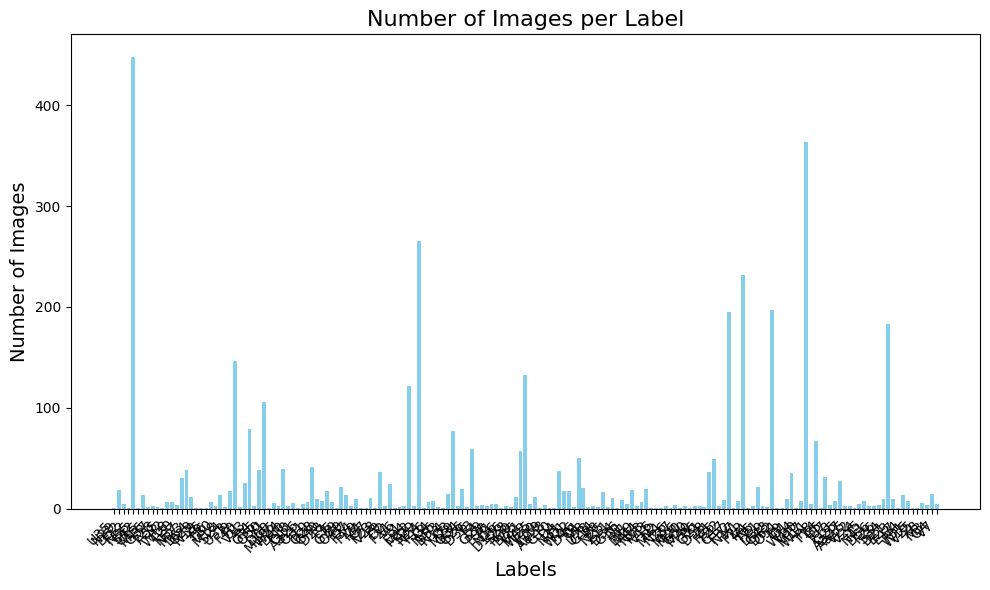

In [2]:
import os
import matplotlib.pyplot as plt

# Set the dataset path from Kaggle's input directory
data_path = '/kaggle/input/hieroglyphs-dataset'  # Update with your dataset name

# Count images in each label folder
label_counts = {}
for label_folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, label_folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        num_images = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])  # Count image files
        label_counts[label_folder] = num_images

# Plot histogram
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Number of Images per Label', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [3]:
import os
import random
import shutil
from PIL import Image, ImageOps

# Set the dataset path for Kaggle (input folder)
data_path = '/kaggle/input/hieroglyphs-dataset'  # Update with your dataset name
target_count = 25  # Target number of images per folder
balanced_data_path = '/kaggle/working/Hieroglyphs_Balanced_Dataset'  # New directory for the balanced dataset

# Clean the target directory before processing (remove existing files/folders)
if os.path.exists(balanced_data_path):
    shutil.rmtree(balanced_data_path)  # Delete the directory and all its contents
os.makedirs(balanced_data_path, exist_ok=True)  # Recreate the empty directory

# Function to ensure the image is grayscale, resized to 100x100, and saved as JPG
def process_image(image_path, save_path):
    try:
        image = Image.open(image_path)

        # Convert to grayscale
        image = image.convert('L')

        # Resize the image to 100x100 pixels
        image_resized = image.resize((100, 100))

        # Save the image as JPEG format
        image_resized.save(save_path, format="JPEG")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Function to downsample images (in the working directory)
def downsample(folder_path, images, target_count):
    random.shuffle(images)
    for image in images[target_count:]:  # Remove extra images
        os.remove(os.path.join(folder_path, image))  # Remove from working directory

# Function to apply random augmentations, convert to grayscale, and resize
def augment_image(image_path, save_path):
    try:
        image = Image.open(image_path)

        # Convert to grayscale
        image = image.convert('L')

        # Apply random horizontal flip
        if random.random() < 0.5:
            image = ImageOps.mirror(image)

        # Apply random rotation
        if random.random() < 0.5:
            image = image.rotate(random.choice([90, 180, 270]))  # Rotate by 90, 180, or 270 degrees

        # Resize the image to 100x100 pixels
        image_resized = image.resize((100, 100))

        # Save the image as JPEG format
        image_resized.save(save_path, format="JPEG")
    except Exception as e:
        print(f"Error augmenting {image_path}: {e}")

# Function to upsample using augmentation and save to the new directory
def upsample_and_save_to_new_directory(folder_path, images, target_count, label_folder_name):
    # Create the corresponding label folder in the new directory if it doesn't exist
    new_label_folder = os.path.join(balanced_data_path, label_folder_name)
    os.makedirs(new_label_folder, exist_ok=True)

    augmented_images = set()  # Track augmented images to avoid duplication
    current_count = len(images)

    while current_count < target_count:
        image_to_augment = random.choice(images)

        # Avoid augmenting the same image repeatedly
        if image_to_augment in augmented_images:
            continue

        # Shorten the augmented image name to prevent long file paths
        new_image_name = f"aug_{current_count}_{os.path.basename(image_to_augment)}"  # Shortened name
        new_image_path = os.path.join(new_label_folder, new_image_name)

        # Augment and save the image to the new directory
        augment_image(os.path.join(folder_path, image_to_augment), new_image_path)

        # Add the augmented image to the list and set
        images.append(new_image_name)
        augmented_images.add(image_to_augment)
        current_count += 1

# Process each folder in the dataset
for label_folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, label_folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        image_count = len(images)

        # Ensure the label folder exists in the balanced dataset directory
        balanced_label_folder = os.path.join(balanced_data_path, label_folder)
        os.makedirs(balanced_label_folder, exist_ok=True)

        # Process original images: convert, resize, and save as JPG
        for image in images:
            original_image_path = os.path.join(folder_path, image)
            new_image_path = os.path.join(balanced_label_folder, image)
            process_image(original_image_path, new_image_path)  # Convert and save as JPG

        # Downsampling or upsampling based on image count
        if image_count > target_count:
            print(f"Downsampling {label_folder}: {image_count} -> {target_count}")
            downsample(balanced_label_folder, images, target_count)  # Downsample in the working directory
        elif image_count < target_count:
            print(f"Upsampling {label_folder}: {image_count} -> {target_count}")
            upsample_and_save_to_new_directory(balanced_label_folder, images, target_count, label_folder)
        else:
            print(f"{label_folder} already balanced with {image_count} images.")


Upsampling U35: 1 -> 25
Upsampling N29: 18 -> 25
Upsampling D52: 5 -> 25
Upsampling F12: 1 -> 25
Downsampling N35: 448 -> 25
Upsampling S42: 1 -> 25
Upsampling U15: 13 -> 25
Upsampling M16: 2 -> 25
Upsampling G37: 3 -> 25
Upsampling T28: 2 -> 25
Upsampling A55: 1 -> 25
Upsampling Y2: 7 -> 25
Upsampling W18: 7 -> 25
Upsampling T20: 4 -> 25
Downsampling N37: 30 -> 25
Downsampling M23: 38 -> 25
Upsampling D54: 12 -> 25
Upsampling O29: 1 -> 25
Upsampling N19: 1 -> 25
Upsampling X6: 1 -> 25
Upsampling H6: 7 -> 25
Upsampling T30: 3 -> 25
Upsampling M18: 13 -> 25
Upsampling S24: 2 -> 25
Upsampling U33: 17 -> 25
Downsampling I9: 146 -> 25
Upsampling F40: 2 -> 25
U1 already balanced with 25 images.
Downsampling V13: 79 -> 25
Upsampling R4: 3 -> 25
Downsampling G35: 38 -> 25
Downsampling O50: 106 -> 25
Upsampling Y1: 1 -> 25
Upsampling D60: 6 -> 25
Upsampling M195: 3 -> 25
Downsampling W24: 39 -> 25
Upsampling D10: 3 -> 25
Upsampling F18: 6 -> 25
Upsampling O11: 1 -> 25
Upsampling Aa26: 5 -> 25


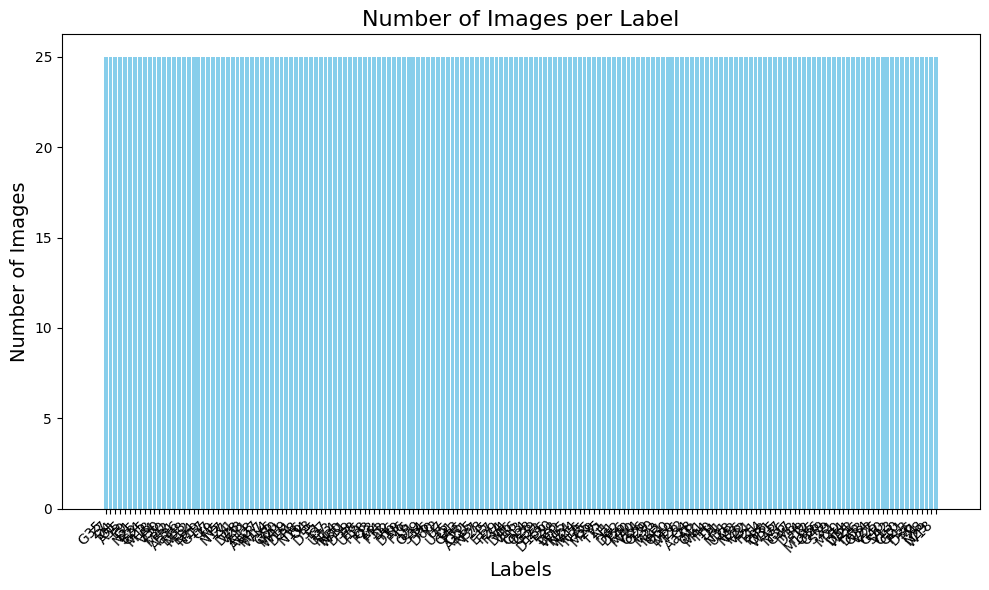

In [4]:
import os
import matplotlib.pyplot as plt

# Set the dataset path from Kaggle's input directory
data_path = '/kaggle/working/Hieroglyphs_Balanced_Dataset'  # Update with your dataset name

# Count images in each label folder
label_counts = {}
for label_folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, label_folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        num_images = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])  # Count image files
        label_counts[label_folder] = num_images

# Plot histogram
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Number of Images per Label', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the base path of your dataset
base_path = '/kaggle/working/Hieroglyphs_Balanced_Dataset'  

# Define the split proportions
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Initialize lists for train, validation, and test images
train_images = []
val_images = []
test_images = []
labels = []

# Traverse through the folders (each folder is a label)
for label_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, label_folder)
    if os.path.isdir(folder_path):
        # Get all images in the current label folder
        images = [os.path.join(folder_path, image) for image in os.listdir(folder_path) if image.endswith(('.jpg', '.png', '.jpeg'))]

        # Prepare labels for stratified sampling
        image_labels = [label_folder] * len(images)

        # Stratified train/validation/test split
        train, temp, train_labels, temp_labels = train_test_split(
            images, image_labels, train_size=train_size, stratify=image_labels, random_state=42
        )
        val, test, val_labels, test_labels = train_test_split(
            temp, temp_labels, test_size=test_size/(test_size+val_size), stratify=temp_labels, random_state=42
        )

        # Append to the final lists
        train_images.extend(train)
        val_images.extend(val)
        test_images.extend(test)

        # Add corresponding labels
        labels.extend(train_labels)
        labels.extend(val_labels)
        labels.extend(test_labels)

# Check the result of the split
print(f"Train images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

# Optionally, you can move the files to new directories for training, validation, and testing
def move_files(image_paths, target_folder):
    for image_path in image_paths:
        label_folder = os.path.basename(os.path.dirname(image_path))  # Extract label from folder name
        target_label_folder = os.path.join(target_folder, label_folder)
        os.makedirs(target_label_folder, exist_ok=True)
        shutil.copy(image_path, target_label_folder)

# Define the output directories for the split datasets
train_dir =   '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

# Move images to corresponding directories
move_files(train_images, train_dir)
move_files(val_images, val_dir)
move_files(test_images, test_dir)


Train images: 2907
Validation images: 684
Test images: 684


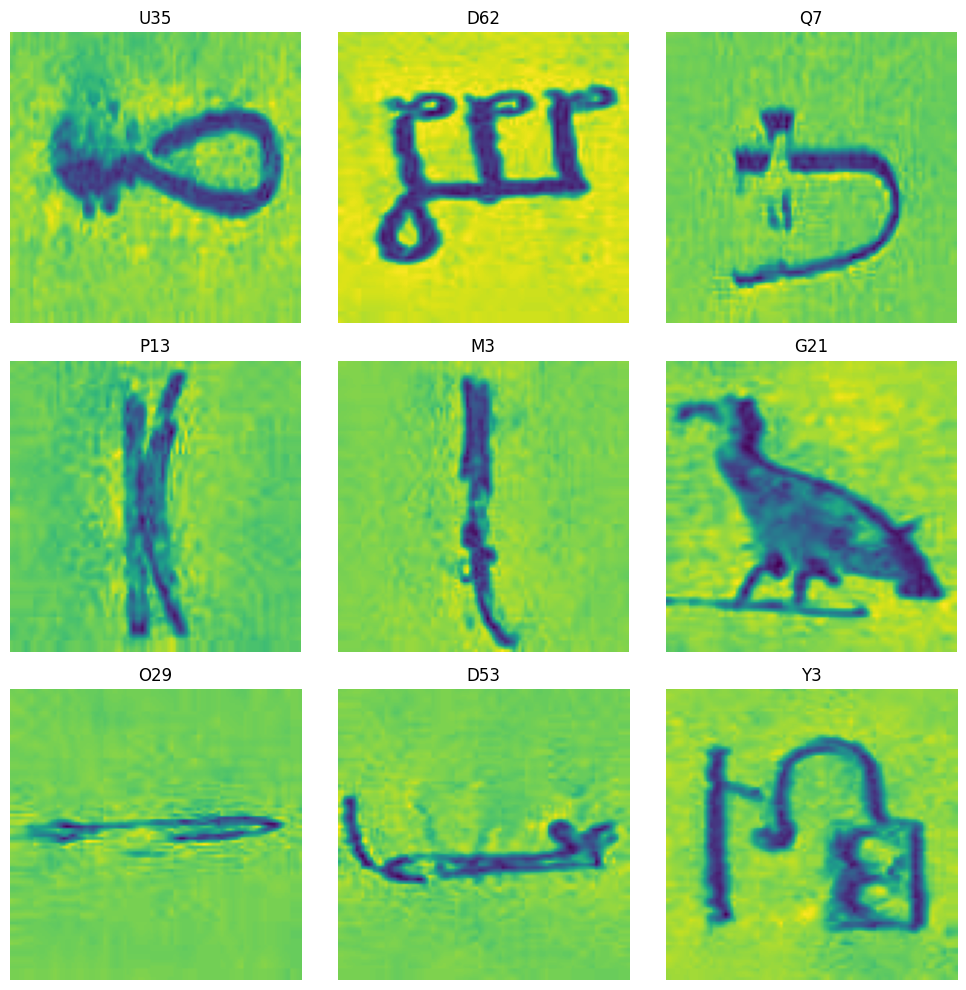

In [6]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the base path for your train dataset
train_dir = '/kaggle/working/train'  # Update this with your train dataset path

# Collect all image paths and their corresponding labels
image_paths = []
image_labels = []

for label_folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, label_folder)
    if os.path.isdir(folder_path):
        # Get all images in the current label folder
        for image in os.listdir(folder_path):
            if image.endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(folder_path, image))
                image_labels.append(label_folder)

# Randomly select a small patch of images (e.g., 9 images)
num_images = 9  # Number of images to display
selected_indices = random.sample(range(len(image_paths)), num_images)

# Create a subplot for displaying images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid for 9 images
axes = axes.flatten()

# Plot the selected images with their labels
for i, idx in enumerate(selected_indices):
    image_path = image_paths[idx]
    label = image_labels[idx]

    # Open and display the image
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(label, fontsize=12)
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


________________

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Path to the train dataset
data_path = "/kaggle/working/train"

X_train = []
y_train = []

# List all class labels (folder names)
allowed_labels = os.listdir(data_path)

for label in allowed_labels:
    class_folder = os.path.join(data_path, label)
    
    if os.path.isdir(class_folder):  # Check if it is a directory
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            
            try:
                # Load the image and convert it to an array
                img = load_img(file_path, target_size=(299, 299))  # Resize the image to 299x299
                img_array = img_to_array(img) / 255.0  # Normalize the image to [0, 1]
                
                # Append the image array and corresponding label
                X_train.append(img_array)
                y_train.append(label)  # Class label as string
                
            except Exception as e:
                print(f"Error processing image {file_path}: {e}")

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


print(f"Loaded {len(X_train)} images with {len(np.unique(y_train))} unique labels.")


Loaded 2907 images with 171 unique labels.


In [8]:
# Load validation dataset
val_data_path = "/kaggle/working/val"

X_val = []
y_val = []

for label in os.listdir(val_data_path):
    class_folder = os.path.join(val_data_path, label)
    if os.path.isdir(class_folder):
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            try:
                img = load_img(file_path, target_size=(299, 299))
                img_array = img_to_array(img) / 255.0
                X_val.append(img_array)
                y_val.append(label)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

# Convert to numpy arrays
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"Loaded {len(X_val)} validation images with {len(np.unique(y_val))}labels.")

Loaded 684 validation images with 171labels.


In [9]:
# Load test dataset
test_data_path = "/kaggle/working/test"

X_test = []
y_test = []

for label in os.listdir(test_data_path):
    class_folder = os.path.join(test_data_path, label)
    if os.path.isdir(class_folder):
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            try:
                img = load_img(file_path, target_size=(299, 299))
                img_array = img_to_array(img) / 255.0
                X_test.append(img_array)
                y_test.append(label)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

# Convert to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Loaded {len(X_test)} test images with {len(np.unique(y_test))} labels.")


Loaded 684 test images with 171 labels.


In [10]:
# Convert class labels to integer values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_one_hot = to_categorical(y_train_encoded)  # One-hot encode the integer labels

# Encode validation labels
y_val_encoded = label_encoder.transform(y_val)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))

# Encode and one-hot encode test labels
y_test_encoded = label_encoder.transform(y_test)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

# Building the model

In [11]:
def build_vgg16_transfer_model(input_shape, n_classes, learning_rate=1e-4):
    # Load VGG16 with pretrained ImageNet weights
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom top layers
    x = base_model.output
    x = Flatten()(x)  # Flatten the output for Dense layers
    x = Dense(4096, activation='relu')(x)  # Emulating AlexNet's dense layers
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation='softmax')(x)  # Final classification layer
    
    # Compile the model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
def build_inceptionv3_model(input_shape, n_classes, learning_rate=1e-4):
    weights_path = '/kaggle/input/inception_v3-weights_notop/keras/default/1/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = InceptionV3(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(weights_path)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers with regularization and dropout
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    output = Dense(n_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
    return model


In [13]:

def build_xception_model(input_shape, n_classes, learning_rate=1e-4):
    weights_path = '/kaggle/input/xception-weights_notop/keras/default/1/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = Xception(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(weights_path)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers with regularization and dropout
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    output = Dense(n_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Training and evaluation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply the augmentation to the training data
datagen.fit(X_train)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train Models
results = {}

In [15]:
# VGG16
print("Training VGG16...")
vgg16_model = build_vgg16_transfer_model(input_shape=(299, 299, 3), n_classes=len(label_encoder.classes_), learning_rate=1e-4)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
vgg16_history = vgg16_model.fit(
    X_train, y_train_one_hot, batch_size=32,
    validation_data=(X_val, y_val_one_hot),
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on Test Data
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(X_test, y_test_one_hot)
print(f"VGG16 Test Accuracy: {vgg16_test_accuracy:.2f}")

# Save Results
results["VGG16"] = {"model": vgg16_model, "history": vgg16_history, "test_accuracy": vgg16_test_accuracy}
vgg16_model.save_weights("VGG16_model.weights.h5")
vgg16_model.save("VGG16_model.h5")
print("VGG16 weights and model saved!")



Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 80s 650ms/step - accuracy: 0.0031 - loss: 5.7053 - val_accuracy: 0.0336 - val_loss: 5.0186 - learning_rate: 1.0000e-04
Epoch 2/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 324ms/step - accuracy: 0.0179 - loss: 5.0932 - val_accuracy: 0.1009 - val_loss: 4.8381 - learning_rate: 1.0000e-04
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 334ms/step - accuracy: 0.0390 - loss: 4.8370 - val_accuracy: 0.1155 - val_loss: 4.4450 - learning_rate: 1.0000e-04
Epoch 4/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.0650 - loss: 4.4567 - val_accuracy: 0.1827 - val_loss: 3.9566 - learning_rate: 1.0000e-04
Epoch 5/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.1186 - loss: 4.0239 - val_accuracy: 0.2895 - val_loss: 3.4761 - learning_rate: 1.0000e-04
Epoch 6/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.1698 - loss: 3.6038 - val_accuracy: 0.3962 - val_loss: 3.0300 - learning_rate: 

In [17]:
import tensorflow as tf
# InceptionV3
print("Training InceptionV3...")

inceptionv3_model = build_inceptionv3_model(input_shape=(299, 299, 3), n_classes=len(label_encoder.classes_))
inceptionv3_history = inceptionv3_model.fit(X_train, y_train_one_hot, batch_size=16,
                                        validation_data=(X_val, y_val_one_hot),
                                        epochs=20)

inceptionv3_test_loss, inceptionv3_test_accuracy = inceptionv3_model.evaluate(X_test, y_test_one_hot)
print(f"InceptionV3 Test Accuracy: {inceptionv3_test_accuracy:.2f}")
results["InceptionV3"] = {"model": inceptionv3_model, "history": inceptionv3_history, "test_accuracy": inceptionv3_test_accuracy}
inceptionv3_model.save_weights("InceptionV3_model.weights.h5")
inceptionv3_model.save("InceptionV3_model.h5")
print("InceptionV3 weights and model saved!")


Training InceptionV3...
Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 56s 215ms/step - accuracy: 0.0078 - loss: 15.1987 - val_accuracy: 0.1725 - val_loss: 12.8411
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.1134 - loss: 12.2880 - val_accuracy: 0.3757 - val_loss: 10.6634
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.2510 - loss: 10.2818 - val_accuracy: 0.5556 - val_loss: 9.1105
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.3907 - loss: 8.8161 - val_accuracy: 0.6301 - val_loss: 7.9951
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.4776 - loss: 7.7915 - val_accuracy: 0.6915 - val_loss: 7.1874
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.5370 - loss: 7.0082 - val_accuracy: 0.7164 - val_loss: 6.5616
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.5747 - loss: 6.4757 - val_accuracy: 0.7383 - val_loss: 6.0686
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accu

In [22]:

# Xception

print("Training Xception...")

xception_model = build_xception_model(input_shape=(299, 299, 3), n_classes=len(label_encoder.classes_))
xception_history = xception_model.fit(
    X_train, y_train_one_hot, batch_size=16,
    validation_data=(X_val, y_val_one_hot),
    epochs=25
)

xception_test_loss, xception_test_accuracy = xception_model.evaluate(X_test, y_test_one_hot)
print(f"Xception Test Accuracy: {xception_test_accuracy:.2f}")
results["Xception"] = {"model": xception_model, "history": xception_history, "test_accuracy": xception_test_accuracy}
xception_model.save_weights("Xception_model.weights.h5")
xception_model.save("Xception_model.h5")
print("Xception weights and model saved!")


Training Xception...
Epoch 1/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - accuracy: 0.0292 - loss: 19.5842 - val_accuracy: 0.3363 - val_loss: 14.3963
Epoch 2/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.2570 - loss: 13.2699 - val_accuracy: 0.5307 - val_loss: 10.5742
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.4101 - loss: 9.9268 - val_accuracy: 0.5936 - val_loss: 8.4433
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.5054 - loss: 8.0453 - val_accuracy: 0.6447 - val_loss: 7.1730
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.5417 - loss: 6.9193 - val_accuracy: 0.6813 - val_loss: 6.3470
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.5878 - loss: 6.1584 - val_accuracy: 0.7076 - val_loss: 5.7810
Epoch 7/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.6248 - loss: 5.6287 - val_accuracy: 0.7076 - val_loss: 5.3824
Epoch 8/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - a

# Visualize Training Results

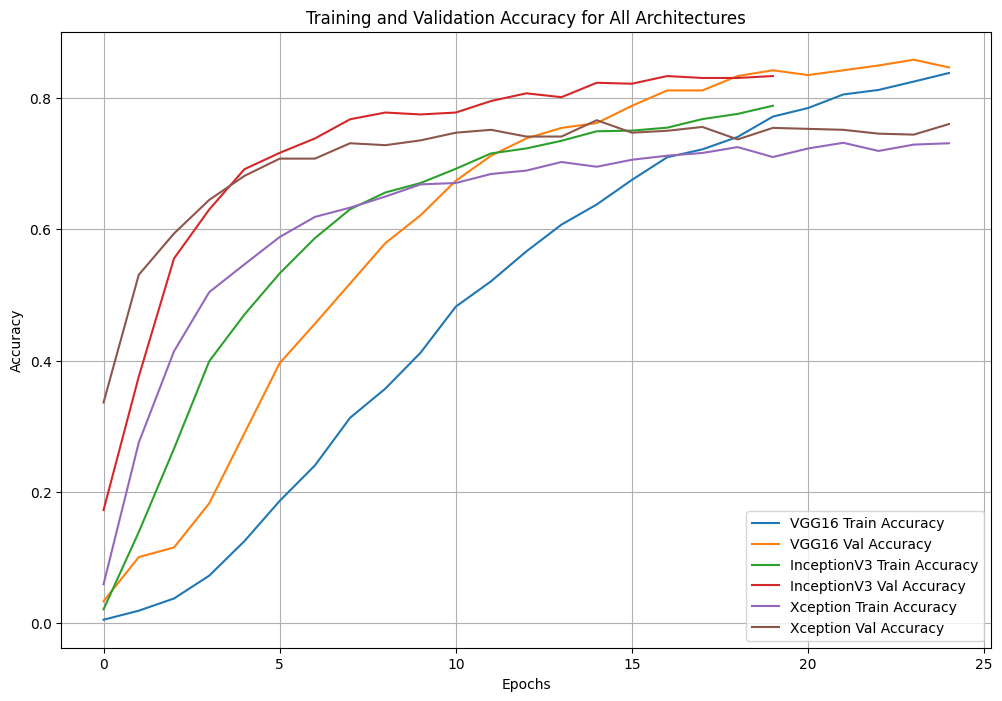

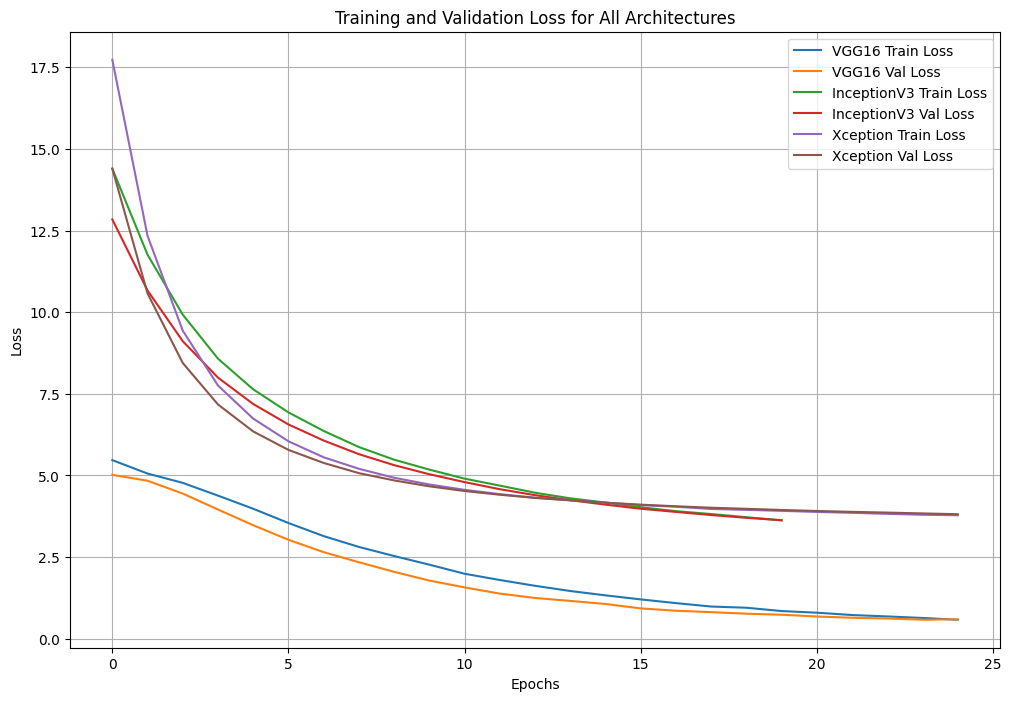

VGG16: Test Accuracy = 0.83
InceptionV3: Test Accuracy = 0.84
Xception: Test Accuracy = 0.76


In [23]:
# Compare Training and Validation Accuracy
plt.figure(figsize=(12, 8))
for arch_name, result in results.items():
    plt.plot(result["history"].history["accuracy"], label=f"{arch_name} Train Accuracy")
    plt.plot(result["history"].history["val_accuracy"], label=f"{arch_name} Val Accuracy")

plt.title("Training and Validation Accuracy for All Architectures")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Compare Training and Validation Loss
plt.figure(figsize=(12, 8))
for arch_name, result in results.items():
    plt.plot(result["history"].history["loss"], label=f"{arch_name} Train Loss")
    plt.plot(result["history"].history["val_loss"], label=f"{arch_name} Val Loss")

plt.title("Training and Validation Loss for All Architectures")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Print Test Accuracy for Each Model
for arch_name, result in results.items():
    print(f"{arch_name}: Test Accuracy = {result['test_accuracy']:.2f}")


# Confusion matrix


Confusion Matrix for VGG16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step


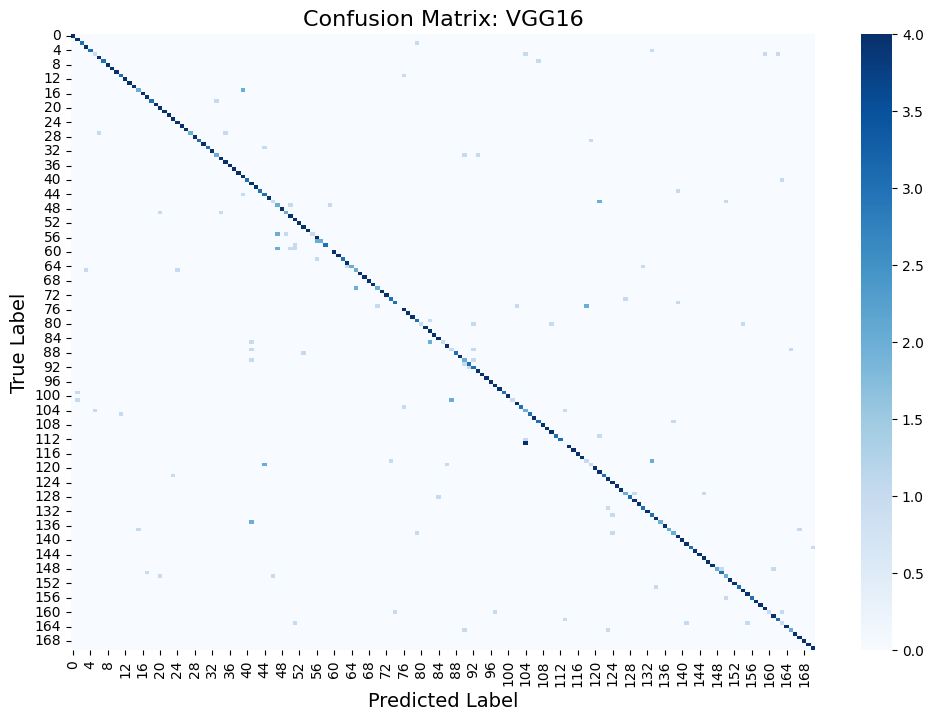


Confusion Matrix for InceptionV3
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


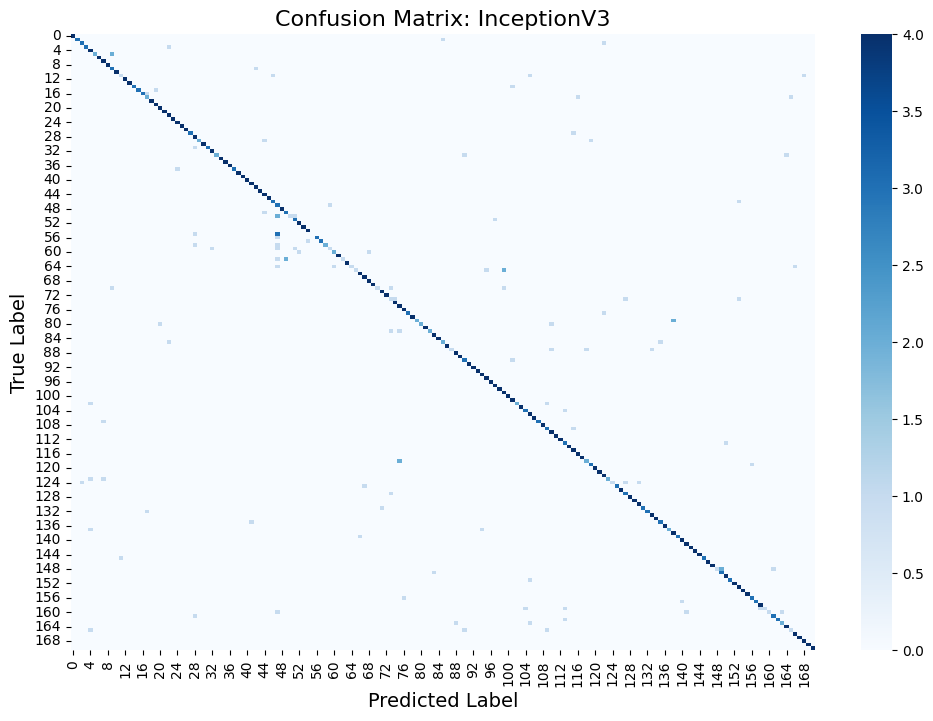


Confusion Matrix for Xception
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step


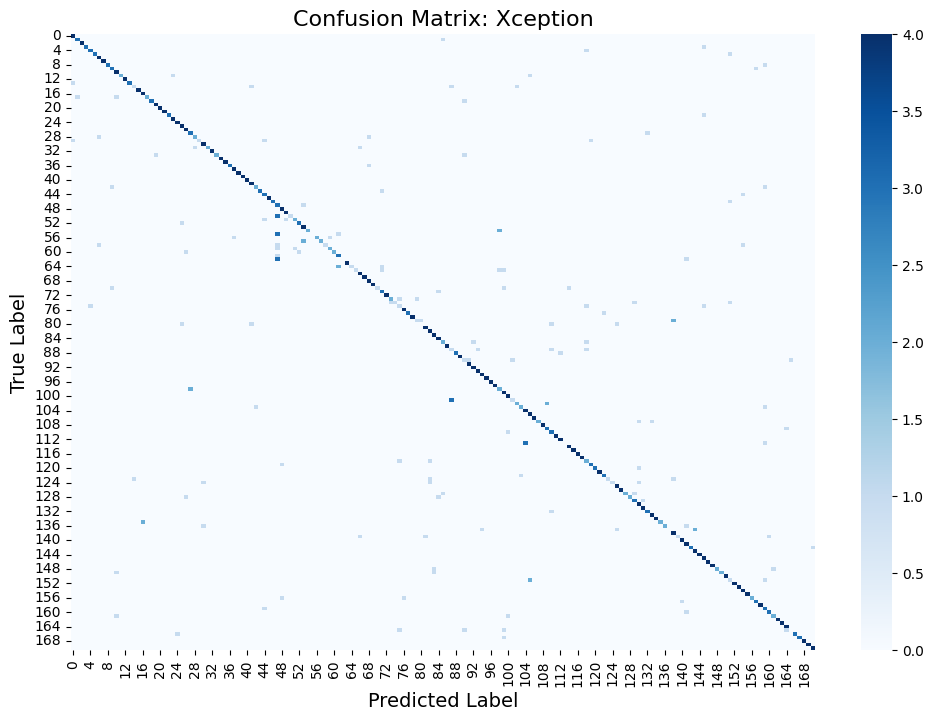

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot confusion matrix for each model
for model_name, result in results.items():
    print(f"\nConfusion Matrix for {model_name}")
    
    # Get predictions
    y_pred = result["model"].predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test_one_hot.argmax(axis=1)
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.show()


#  Comparison Table of Metrics

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step
         Model  Accuracy  Precision    Recall  F1 Score
0        VGG16  0.833333   0.849230  0.833333  0.822079
1  InceptionV3  0.836257   0.870732  0.836257  0.825272
2     Xception  0.763158   0.792794  0.763158  0.743963


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


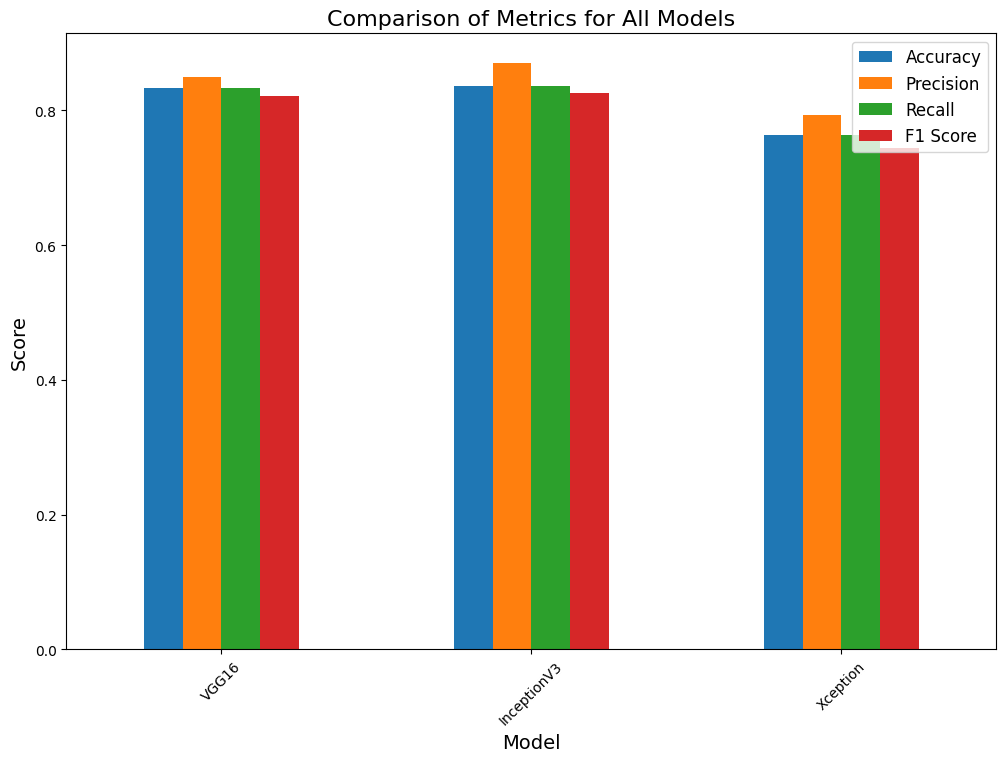

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Collect metrics
comparison_metrics = []
for model_name, result in results.items():
    y_pred = result["model"].predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test_one_hot.argmax(axis=1)
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average="weighted")
    recall = recall_score(y_true_classes, y_pred_classes, average="weighted")
    f1 = f1_score(y_true_classes, y_pred_classes, average="weighted")
    
    comparison_metrics.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Create a DataFrame to summarize results
import pandas as pd

metrics_df = pd.DataFrame(comparison_metrics)
print(metrics_df)

# Visualize the comparison
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8))
plt.title("Comparison of Metrics for All Models", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.show()
